In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-23_2021-07-23-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,82973,None,None,61299.338455
2020-06-13,82974,None,None,58135.774640
2020-06-14,82975,None,None,55038.457467
2020-06-15,82976,None,None,52280.168339
2020-06-16,82977,None,None,49810.304969
...,...,...,...,...
2021-07-19,83375,None,None,644801.163022
2021-07-20,83376,None,None,668167.424057
2021-07-21,83377,None,None,691709.063806


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-22_2021-07-22-18-03.pickle


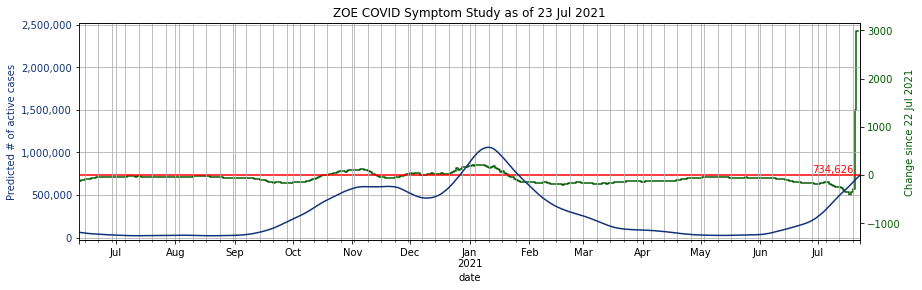

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

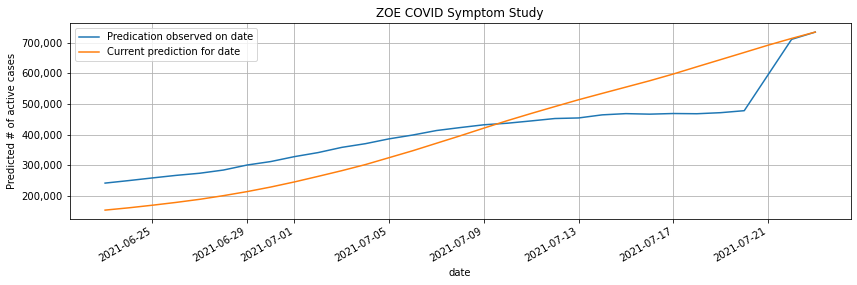

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Fri 23 Jul 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
3,Stockton-on-Tees,E06000004,3.923812
279,Barnsley,E08000016,3.147339
151,Blaby,E07000129,3.080190
342,Bridgend,W06000013,2.669399
203,Scarborough,E07000168,2.638439
350,Havering,E09000016,2.589312
60,Thurrock,E06000034,2.586201
15,"Kingston upon Hull, City of",E06000010,2.515163
297,Falkirk,S12000014,2.331258
164,Chorley,E07000118,2.229213
